In [1]:
# First some imports and setup
%pylab inline
import seaborn as sns
sns.set(style='ticks')
%cd ..
from remotelets import *
from IPython.display import display, clear_output
import pandas as pd
import visa,time

# Set up a visa resource manager
rm = visa.ResourceManager('@ni')
print 'Available visa resources: ', rm.list_resources()

visa_resource_string = 'USB0::0x2A8D::0x1E01::SG56360004::INSTR'

Populating the interactive namespace from numpy and matplotlib
C:\Users\dkuester\Documents\src\remotelets
Available visa resources:  (u'USB0::0x2A8D::0x1E01::SG56360004::INSTR', u'ASRL1::INSTR', u'ASRL3::INSTR')


# Device control demo

### Instrument control with bare pyvisa
pyvisa gives us methods for sending SCPI command strings to instruments, and receiving instrument responses. Code based on [the manufacturer's programming manual](http://literature.cdn.keysight.com/litweb/pdf/U2041-90003.pdf) looks like this:

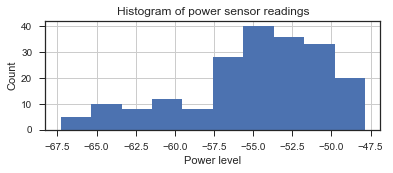

In [3]:
sensor = rm.open_resource(visa_resource_string, read_termination = '\n', write_termination = '\n')

# this try...finally structure ensures the visa link to the sensor is closed,
# even if there's an exception in the try block
try:
    # Configure
    sensor.write('SYST:PRES;*OPC')      # Presets the U2040 X-Series to default values.
    sensor.query('*OPC?')              
    sensor.write('SENS:FREQ 1e9')       # Sets the frequency to 1 GHz.
    sensor.write('SENS:MRAT FAST')      # Sets the measurement speed to fast mode.
    sensor.write('TRIG:COUN 200')       # Configure for 200 readings per call to FETC?
    sensor.write('SENS:SWE:APER 20e-6') # Sets the aperture size to 20 μs (50000 measurements per second).
    sensor.write('TRIG:SOUR IMM')       # Configure sensor for continuous triggering
    sensor.write('INIT:CONT ON;*OPC')   # Configure sensor for continuous triggering
    sensor.query('*OPC?')               # Block until we get a response
    
    response = sensor.query('FETC?',delay=0.1)                 # Pull in readings from the sensor
    power = pd.Series([float(s) for s in response.split(',')]) # Convert comma-seperated list of power levels to floats
finally:
    sensor.close()

power.hist(figsize=(6,2)); xlabel('Power level'); ylabel('Count'); title('Histogram of power sensor readings')

Suppose this task is done now, but it's a couple of weeks later and I need to make an adjustment: my statistician tells me that I need 500 points. Easy! Let's just change 200 to 500 and see what happens:

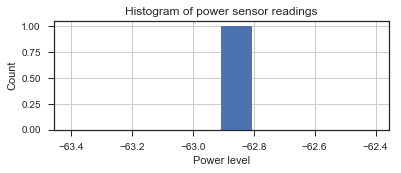

In [4]:
rm = visa.ResourceManager('@ni')
sensor = rm.open_resource(visa_resource_string, read_termination = '\n', write_termination = '\n')

try:
    # Configure
    sensor.write('SYST:PRES;*OPC')      # Presets the U2040 X-Series to default values.
    sensor.query('*OPC?')              
    sensor.write('SENS:FREQ 1e9')       # Sets the frequency to 1 GHz.
    sensor.write('SENS:MRAT FAST')      # Sets the measurement speed to fast mode.
    sensor.write('TRIG:COUN 500')       # Configure for 200 readings per call to FETC?
    sensor.write('SWE:APER 20e-6')      # Sets the aperture size to 20 μs (50000 measurements per second).
    sensor.write('TRIG:SOUR IMM')       # Configure sensor for continuous triggering
    sensor.write('INIT:CONT ON;*OPC')   # Configure sensor for continuous triggering
    sensor.query('*OPC?')               # Block until we get a response
    
    response = sensor.query('FETC?',delay=0.1)                 # Pull in readings from the sensor
    power = pd.Series([float(s) for s in response.split(',')]) # Convert comma-seperated list of power levels to floats
finally:
    # Use of this try...finally structure ensures the visa link to the sensor is closed,
    # even if there's an error in the try block
    sensor.close()
    
power.hist(figsize=(6,2)); xlabel('Power level'); ylabel('Count'); title('Histogram of power sensor readings')

We've run into an annoyance here: one data point back instead of 500. Now I have to dig up [the manufacturer's programming manual](http://literature.cdn.keysight.com/litweb/pdf/U2041-90003.pdf) again to do some searching to find out that the sensor only supports up to 200 at a time.

#### pain points
* debugging changes to bare SCPI strings means going back to the manufacturer pdf
* getting numeric data means messy stuff like this *every time*:
  ```python
  power = pd.Series([float(s) for s in sensor.query('FETC?',delay=0.1).split(',')])
  ```
* modern code editors don't help us with perks here --- they don't know about the SCPI strings in these instruments (no tab autocomplete)
* silent failure when I send bad strings, especially on sensors like this that have no displays to show error. If I send an invalid command,
  ```python
  sensor.write('FREQ 1e9')
  ```
  or set a frequency that is out of bounds,
  ```python
  sensor.write('FREQ 100e9')
  ```
  then I get *no feedback* that from the instrument or my script that the SCPI command did not work. I may think that I've set the frequency in the instrument, but I have not. I have to do debugging just to see if the command is valid or not.

These problems lead toward similar ends: **the next person to try to automate this instrument (either me or another person) is likely to start over from scratch instead of benefit from what I've already learned here.** In other words, my code is not maintainable, and not reusable.

### Reusable driver code based on remotelets
`remotelets` builds on pyvisa. The point of remotelets is to make it easier write reusable code to automate instrumentation tasks, make the process of coding automation coding faster and more pleasant. We'd start by making a reusable driver class that has special *attributes* that map closely to the SCPI commands:

In [6]:
class KeysightU2040XSeries(VISAInstrument):
    ''' This is my cool driver for Keysight U2040 X-Series power sensors
    '''
    connection_settings     = {'read_termination':  '\n',
                               'write_termination': '\n'}

    initiate_continuous     = SCPI(Bool(),                                         'INIT:CONT')    
    output_trigger          = SCPI(Bool(),                                         'OUTP:TRIG')
    trigger_source          = SCPI(EnumBytes(['IMM','INT','EXT','BUS','INT1']),    'TRIG:SOUR')
    trigger_count           = SCPI(Int(min=1,max=200,step=1,help="help me"),       'TRIG:COUN')
    measurement_rate        = SCPI(EnumBytes(['NORM','DOUB','FAST']),              'SENS:MRAT')
    sweep_aperture          = SCPI(Float(min=20e-6, max=200e-3,label='s'),         'SWE:APER')
    frequency               = SCPI(Float(min=10e6, max=18e9,step=1e-3,label='Hz'), 'SENS:FREQ')
    
    def preset (self, block=True):
        if block:
            self.link.write('SYST:PRES;*OPC')
            self.link.query('*OPC?')
        else:
            self.link.write('SYST:PRES')

    def fetch (self):
        ''' Return a single number or pandas Series containing the power readings
        '''
        response = self.link.query('FETC?')
        return pd.Series([float(s) for s in response.split(',')])

We'd collect this with other drivers, somewhere other people can easily more functions and parameters (how about a git repository?). A few points about what we've set up here:
* `class KeysightU2040XSeries(VISAInstrument)` defines a driver class with all of the features of the generic VISAInstrument from the remotelets module
* `connection_settings` is a dictionary of options that get passed into the resource manager `open_resource` method when we make a connection to the instrument
* Lines that create class attributes with SCPI(...) calls set up all of the logic necessary to get and set simple parameters: the simple instrument settings that determine device state and don't need any arguments
* Other lines we can implement specially, like the `fetch` and `preset` methods

Now we can do the same thing we did at the top without hard-coding strings:

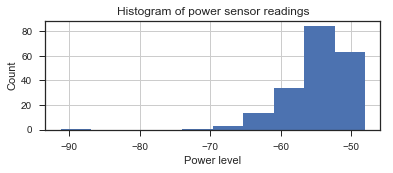

In [7]:
# from remotelets_drivers.power_sensors import KeysightU2040XSeries

sensor = KeysightU2040XSeries(visa_resource_string) # Instantiate the driver
sensor.connected = True # Connect to the hardware

try:
    # Configure
    sensor.preset()
    sensor.frequency           = 1e9
    sensor.measurement_rate    = 'FAST'
    sensor.trigger_count       = 200
    sensor.sweep_aperture      = 20e-6
    sensor.trigger_source      = 'IMM'
    sensor.initiate_continuous = True
    
    power = sensor.fetch()
finally:
    sensor.disconnect()
power.hist(figsize=(6,2)); xlabel('Power level'); ylabel('Count'); title('Histogram of power sensor readings')

There are some key advantages in using the remotelets driver to control the sensor:
* The sensor attributes that we edit, like `frequency`, have names that are more readable and descriptive than the SCPI strings, but it's actually *easier* to type them because of autocompletion
* The sensor driver instance here supports *callbacks*, which means we can hook in other features like loggers (like outputting SQL or csv files) or GUIs.
* Metadata about valid bounds (for numerical parameters) or valid string options (for EnumBytes parameters) is built-in; we don't have to look it up every time we need to change something

As an illustration, suppose now we try to make the change to 500 triggers:

In [8]:
sensor = KeysightU2040XSeries(visa_resource_string) # Instantiate the driver
sensor.connected = True # Connect to the instrument

try:
    # Configure
    sensor.preset()
    sensor.frequency           = 1e9
    sensor.measurement_rate    = 'FAST'
    sensor.trigger_count       = 500
    sensor.sweep_aperture      = 20e-6
    sensor.trigger_source      = 'IMM'
    sensor.initiate_continuous = True
    
    power = sensor.fetch()
finally:
    sensor.disconnect()
    
power.hist(figsize=(6,2)); xlabel('Power level'); ylabel('Count'); title('Histogram of power sensor readings')

TraitError: The value of the 'trigger_count' trait of a KeysightU2040XSeries instance should not be greater than 200, but a value of 500 was specified

**this exception is a good thing: we got immediate feedback that we provided an invalid value, instead of silent failure.**

All we did to make this happen was add the `min=1,max=200` parameters when we set up the `Int` data type for the KeysightU2040XSeries driver; these values are in the programming manual along in the same place we went to find out that the SCPI string is `'TRIG:COUN'`.

### Other perks of instrument control with remotelets
* Real-time "heads-up" display (jupyter notebooks only)

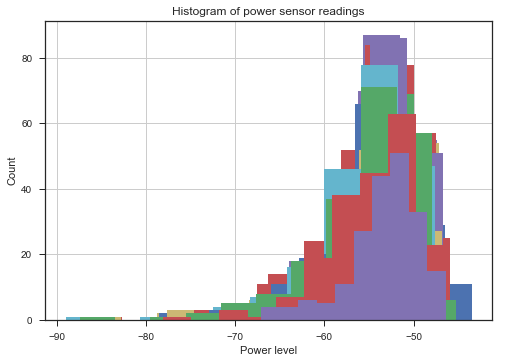

In [9]:
sensor = KeysightU2040XSeries(visa_resource_string)
display(notebooks.watch(sensor))  # Show a real-time monitor of instrument state
sensor.connected = True

try:
    sensor.measurement_rate    = 'FAST'
    sensor.trigger_count       = 200
    sensor.sweep_aperture      = 20e-6
    sensor.trigger_source      = 'IMM'
    sensor.initiate_continuous = True

    # Let's do a loop
    for freq in np.arange(1,15,.5)*1e9:
        sensor.frequency = freq
               
        # fetch and plot
        power = sensor.fetch()
        power.hist();xlabel('Power level'); ylabel('Count'); title('Histogram of power sensor readings')
        
        # Update the plot display
        display(gcf());clear_output(wait=True)        
finally:
     sensor.disconnect()

* Autogenerated docstrings (for help)

In [10]:
# pop up the jupyter notebook help pane
trait=sensor.traits()['frequency']
trait?
help(KeysightU2040XSeries)

Help on class KeysightU2040XSeries in module __main__:

class KeysightU2040XSeries(remotelets.core.VISAInstrument)
 |  This is my cool driver for Keysight U2040 X-Series power sensors
 |  
 |  Method resolution order:
 |      KeysightU2040XSeries
 |      remotelets.core.VISAInstrument
 |      remotelets.core.RemoteDevice
 |      traitlets.traitlets.HasTraits
 |      traitlets.traitlets.HasDescriptors
 |      __builtin__.object
 |  
 |  Methods defined here:
 |  
 |  fetch(self)
 |      Return a single number or pandas Series containing the power readings
 |  
 |  preset(self, block=True)
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |  
 |  frequency
 |      remote trait Float(min=10000000.0,max=18000000000.0,step=0.001)
 |  
 |  initiate_continuous
 |  
 |  measurement_rate
 |      remote trait Enum(['NORM', 'DOUB', 'FAST'])
 |  
 |  output_trigger
 |  
 |  sweep_aperture
 |      remote trait Float(min=2e-05,max=0.2

* Automated logging